# Ordering

An `Ordering` specifies the order in which variables are eliminated during inference (e.g., Gaussian elimination, multifrontal QR). The choice of ordering significantly impacts the computational cost and fill-in (sparsity) of the resulting Bayes net or Bayes tree.

GTSAM provides several algorithms to compute good orderings automatically, such as COLAMD and METIS, or allows you to specify a custom ordering.

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/inference/doc/Ordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet gtsam-develop

In [21]:
import gtsam
from gtsam import Ordering
# Need graph types
from gtsam import SymbolicFactorGraph
from gtsam import symbol_shorthand
import graphviz

X = symbol_shorthand.X
L = symbol_shorthand.L

## Creating an Ordering

Orderings can be created manually or computed automatically from a factor graph.

In [22]:
# Manual creation (list of keys)
manual_ordering = Ordering([X(1), L(1), X(2), L(2), X(0)])
manual_ordering.print("Manual Ordering: ")

Manual Ordering: Position 0: x1, l1, x2, l2, x0


In [23]:
# Automatic creation requires a factor graph
# Let's use a simple SymbolicFactorGraph for structure
graph = SymbolicFactorGraph()
graph.push_factor(X(0))
graph.push_factor(X(0), X(1))
graph.push_factor(X(1), X(2))
graph.push_factor(X(0), L(1))
graph.push_factor(X(1), L(1))
graph.push_factor(X(1), L(2))
graph.push_factor(X(2), L(2))

# COLAMD ordering
colamd_ordering = Ordering.ColamdSymbolicFactorGraph(graph)
colamd_ordering.print("COLAMD Ordering: ")

COLAMD Ordering: Position 0: l1, x0, x1, l2, x2


## Automatic Ordering Algorithms: COLAMD vs METIS

GTSAM provides algorithms to automatically compute an elimination ordering from a factor graph. Two common algorithms are:

1.  **COLAMD (Column Approximate Minimum Degree):** A greedy algorithm that aims to minimize *fill-in* at each elimination step. It typically produces orderings that are good for sparse direct methods executed sequentially.
2.  **METIS:** A graph partitioning algorithm. It aims to find orderings that partition the graph well, often leading to more balanced elimination trees which can be beneficial for parallel computation and sometimes reduce overall fill-in compared to purely local greedy methods like COLAMD, especially on large, structured problems.

Let's illustrate the difference using a 2D grid factor graph.

In [24]:
# Create a 3x4 grid graph
ROWS, COLS = 3, 4

# Use 'x' symbols for grid nodes
X_grid = lambda r, c: X(10 * (r + 1) + c + 1)


def create_grid_graph():
    """Creates a SymbolicFactorGraph representing a 2D grid."""
    graph = SymbolicFactorGraph()
    keys = []
    positions = {}
    for r in range(ROWS):
        for c in range(COLS):
            key = X_grid(r, c)
            positions[key] = gtsam.Point2(c, COLS-r)
            keys.append(key)
            # Add binary factors connecting to right and down neighbors
            if c + 1 < COLS:
                key_right = X_grid(r, c + 1)
                graph.push_factor(key, key_right)
            if r + 1 < ROWS:
                key_down = X_grid(r + 1, c)
                graph.push_factor(key, key_down)
    return graph, keys, positions


grid_graph, grid_keys, positions = create_grid_graph()

Here's the structure of our grid graph. Edges represent factors connecting variables (nodes).

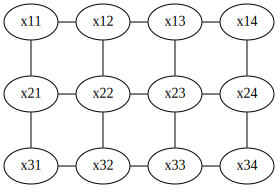

In [25]:
writer = gtsam.DotWriter(binaryEdges = True)
writer.variablePositions = positions
display(graphviz.Source(grid_graph.dot(writer=writer), engine='neato'))

### COLAMD Ordering and Resulting Bayes Net

Now, we compute the COLAMD ordering and eliminate the variables according to this order.

COLAMD Ordering: 
Position 0: x11, x31, x14, x34, x33, x24, x23, x32, x13, x22
Position 10: x21, x12



COLAMD Bayes Net Structure:


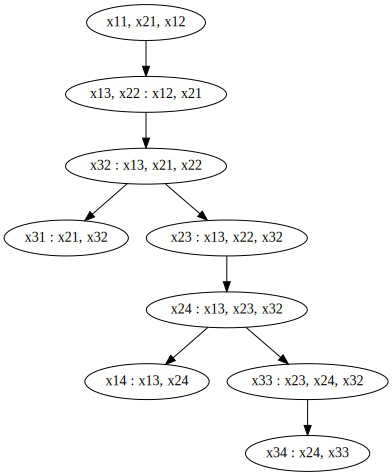

In [26]:
# COLAMD (Column Approximate Minimum Degree) ordering
colamd_ordering = Ordering.ColamdSymbolicFactorGraph(grid_graph)
print("COLAMD Ordering: ")
colamd_ordering.print()

# Eliminate using COLAMD ordering
bayes_tree_colamd = grid_graph.eliminateMultifrontal(colamd_ordering)

# Visualize the resulting Bayes Net
print("\nCOLAMD Bayes Net Structure:")
display(graphviz.Source(bayes_tree_colamd.dot()))

### METIS Ordering and Resulting Bayes Net

Next, we compute the METIS ordering and visualize its resulting Bayes Net. Compare its structure to the one generated by COLAMD.

METIS Ordering: 
Position 0: x34, x23, x14, x24, x13, x32, x11, x31, x21, x12
Position 10: x33, x22

METIS Bayes Net Structure:


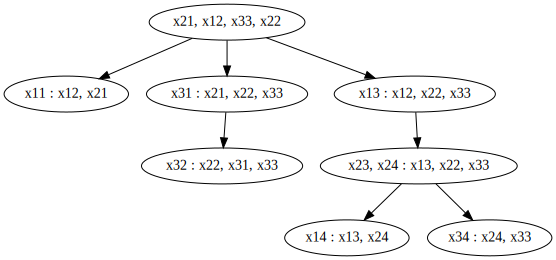

In [27]:
metis_ordering = Ordering.MetisSymbolicFactorGraph(grid_graph)
print("METIS Ordering: ")
metis_ordering.print()

# Eliminate using METIS ordering
bayes_tree_metis = grid_graph.eliminateMultifrontal(metis_ordering)

# Visualize the resulting Bayes Net
print("\nMETIS Bayes Net Structure:")
display(graphviz.Source(bayes_tree_metis.dot()))

### Comparison

Observe the differences in the Bayes tree structures produced by COLAMD and METIS:

*   **COLAMD:** Often produces a more 'stringy' or deeper Bayes tree. The cliques (conditionals in the Bayes tree) might be smaller initially but can grow larger towards the root (variables eliminated last).
*   **METIS:** Tends to produce a more 'bushy' or balanced tree. It tries to partition the graph, eliminating variables within partitions first, leading to potentially larger initial cliques but often a shallower overall structure and smaller separators (variables connecting cliques high up in the tree). 

When should you choose one over the other? The best choice often depends on the specific problem structure and computational goals:

*   **Use COLAMD when:**
    *   You need a good, general-purpose ordering quickly. COLAMD is typically much faster *to compute the ordering itself* than METIS.
    *   You are primarily using a *sequential* solver (running on a single CPU core). COLAMD's greedy strategy is often well-suited for minimizing fill-in in this scenario.
    *   The factor graph is relatively small or doesn't have a highly regular structure where complex partitioning would yield significant benefits.

*   **Use METIS when:**
    *   You are aiming for maximum performance with a *parallel* solver (e.g., using GTSAM's multifrontal solvers with TBB). METIS's graph partitioning approach tends to create more balanced Bayes trees, which allows for better workload distribution across multiple CPU cores.
    *   You are dealing with very large-scale problems, especially those with a regular structure (like large grids, meshes from finite element analysis, or extensive SLAM maps). On such problems, METIS can sometimes find an ordering with significantly less *total fill-in* than COLAMD, leading to faster factorization, even if computing the ordering itself takes longer.
    *   The cost of computing the ordering is negligible compared to the cost of the subsequent factorization and solve steps (e.g., you compute the ordering once for a structure that is solved repeatedly).

**In summary:** COLAMD is a robust and fast default. METIS is often the preferred choice for large-scale problems and parallel execution, potentially offering better final factorization performance at the cost of a slower ordering computation. Experimentation on your specific problem type might be necessary to determine the optimal choice.

For more information on COLAMD and METIS, see [Factor Graphs for Robot Perception](https://www.cs.cmu.edu/~kaess/pub/Dellaert17fnt.pdf).

### Constrained Ordering

Sometimes, we want to force certain variables to be eliminated last (e.g., the current robot pose in SLAM). `Ordering.ColamdConstrainedLast` allows this for COLAMD.

In [28]:
# Example: Constrained COLAMD forcing corners (x0, x24) to be eliminated last
# Note: We use the grid_graph defined earlier
corner_keys = gtsam.KeyVector([X_grid(0, 0), X_grid(ROWS-1, COLS-1)])
constrained_ordering = Ordering.ColamdConstrainedLastSymbolicFactorGraph(grid_graph, corner_keys)
print(f"Constrained COLAMD ({gtsam.DefaultKeyFormatter(corner_keys[0])}, {gtsam.DefaultKeyFormatter(corner_keys[1])} last):")
constrained_ordering.print()

Constrained COLAMD (x11, x34 last):
Position 0: x31, x32, x21, x14, x24, x13, x23, x33, x22, x12
Position 10: x34, x11


## Accessing Elements

An `Ordering` behaves like a vector of keys.

In [29]:
print(f"COLAMD Ordering size: {colamd_ordering.size()}")

# Access by index
key_at_0 = colamd_ordering.at(0)
print(f"Key at position 0 (COLAMD): {gtsam.DefaultKeyFormatter(key_at_0)}")

COLAMD Ordering size: 12
Key at position 0 (COLAMD): x11


## Appending Keys

You can append keys to an existing ordering using `push_back`.

In [30]:
# Use the COLAMD ordering from the grid example
appended_ordering = Ordering(colamd_ordering)
appended_ordering.push_back(L(0)) # Append a landmark key
appended_ordering.push_back(X(ROWS*COLS)) # Append a new pose key x25

appended_ordering.print("Appended Ordering: ")

Appended Ordering: Position 0: x11, x31, x14, x34, x33, x24, x23, x32, x13, x22
Position 10: x21, x12, l0, x12
